In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../src/")
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from process import Doc2VecProcessor
from vectorize import Doc2VecVectorizer
from utils import get_doc_paths, read_labels

raw_docs_dir = "../data/raw_docs/"
labels_dir = "../data/labels/"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Process data

In [2]:
lang = "eng"
raw_doc_paths = get_doc_paths(raw_docs_dir, lang)
dp = Doc2VecProcessor(lang=lang, processed_chunk_sentence_count=None, stride=None)
dp.process(raw_doc_paths)

INFO:root:Processing texts...
100%|██████████| 599/599 [02:37<00:00,  3.80it/s]
INFO:root:Processed texts.


In [10]:
lang = "ger"
raw_doc_paths = get_doc_paths(raw_docs_dir, lang)
dp = Doc2VecProcessor(lang=lang, processed_chunk_sentence_count=None, stride=None)
dp.process(raw_doc_paths)

INFO:root:Processing texts...
100%|██████████| 547/547 [01:58<00:00,  4.63it/s]
INFO:root:Processed texts.


In [28]:
lang = "eng"
raw_doc_paths = get_doc_paths(raw_docs_dir, lang)
dp = Doc2VecProcessor(lang=lang, processed_chunk_sentence_count=500, stride=500)
dp.process(raw_doc_paths)

INFO:root:Processing texts...
100%|██████████| 599/599 [02:39<00:00,  3.76it/s]
INFO:root:Processed texts.


In [12]:
lang = "ger"
raw_doc_paths = get_doc_paths(raw_docs_dir, lang)
dp = Doc2VecProcessor(lang=lang, processed_chunk_sentence_count=500, stride=500)
dp.process(raw_doc_paths)

INFO:root:Processing texts...
100%|██████████| 547/547 [03:19<00:00,  2.74it/s]
INFO:root:Processed texts.


# Full documents + Doc2VecDMM + SVR

In [ ]:
lang = "eng"
processed_full_doc_paths = get_doc_paths("../data/processed_doc2vec_full/", lang)
d2vv = Doc2VecVectorizer(dm=1, dm_mean=1)
d2vv.fit(processed_full_doc_paths)
df = d2vv.get_doc_vectors()
labels = read_labels("eng")
df['y'] = df["doc_path"].apply(lambda x: labels[x.split("/")[-1][:-4]])
df = df.drop(columns=['doc_path'])

In [25]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df.drop(columns=['y']).values
y = df["y"].values.ravel()

all_predictions = []
all_labels = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for index, (train_indices, validation_indices) in enumerate(kf.split(X)):
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    validation_X = X[validation_indices, :]
    validation_y = y[validation_indices]
    
    model = SVR(C=30)
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

Fold: 1, TrainMSE: 130.32080475297153, TrainMAE: 5.6551755176841825, ValMSE: 660.8629199253104, ValMAE: 19.07240698031934
Fold: 2, TrainMSE: 151.00113881557442, TrainMAE: 6.178720082327512, ValMSE: 370.8800996269411, ValMAE: 14.169112447036964
Fold: 3, TrainMSE: 150.01656000225623, TrainMAE: 6.267869262316337, ValMSE: 284.46622542459477, ValMAE: 13.070027834189158
Fold: 4, TrainMSE: 146.72748292506944, TrainMAE: 6.001013565923731, ValMSE: 426.97866155943206, ValMAE: 16.129110488255876
Fold: 5, TrainMSE: 149.90582619220487, TrainMAE: 6.234651774488244, ValMSE: 330.0314586240001, ValMAE: 13.908030307843376
Fold: 6, TrainMSE: 145.6034973846239, TrainMAE: 5.9638254061353315, ValMSE: 527.8679069009091, ValMAE: 17.636708189161414
Fold: 7, TrainMSE: 149.98824250171182, TrainMAE: 5.943049073352656, ValMSE: 590.3832967866931, ValMAE: 18.54085460475645
Fold: 8, TrainMSE: 152.84995259073781, TrainMAE: 6.241936325774398, ValMSE: 373.4923250980522, ValMAE: 14.191112616530116
Fold: 9, TrainMSE: 152.

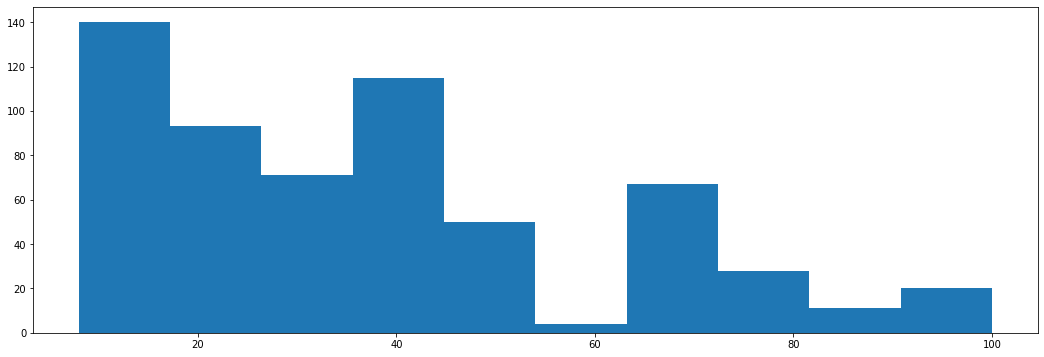

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.hist(all_labels)
plt.show();

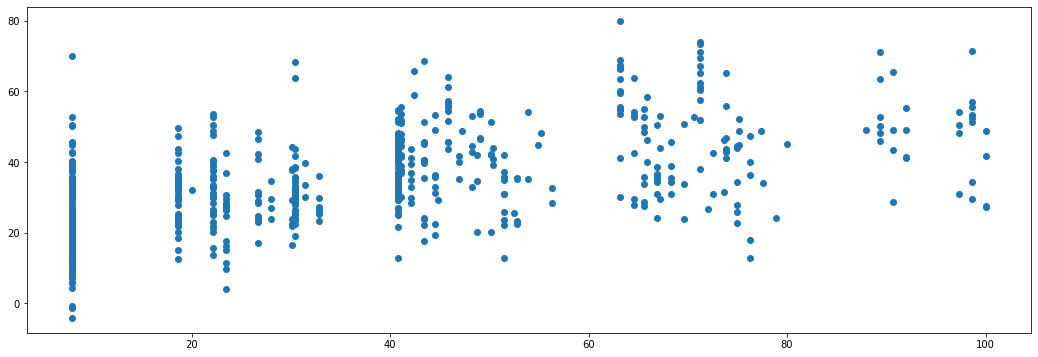

In [27]:
plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.show();

# Chunks of 500 Sentences + Doc2VecDMM + SVR

In [7]:
lang = "eng"
processed_sc_500_st_500_doc_paths = get_doc_paths("../data/processed_doc2vec_sc_500_st_500/", lang)
d2vv = Doc2VecVectorizer(dm=1, dm_mean=1)
d2vv.fit(processed_sc_500_st_500_doc_paths)
df = d2vv.get_doc_vectors()
labels = read_labels("eng")
df['y'] = df["doc_path"].apply(lambda x: labels[x.split("/")[-1][:-4].split("_pt")[0]])
df['book_name'] = df['doc_path'].apply(lambda x: x.split("/")[-1][:-4].split("_pt")[0])


INFO:root:Fitting Doc2VecVectorizer...
DEBUG:gensim.utils:starting a new internal lifecycle event log for Doc2Vec
INFO:gensim.utils:Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w4,mc2,s0.001,t4)', 'datetime': '2021-04-24T13:17:59.369939', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:collected 173326 word types and 5682 unique tags from a corpus of 5682 examples and 58168457 words
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 100886 unique words (58.20592409678871%% of original 173326, drops 72440)', 'datetime': '2021-04-24T13:18:23.379697', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep

  3%|▎         | 1/30 [00:43<21:10, 43.81s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 100886 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-24T13:19:08.934455', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 2.20% examples, 879691 words/s, in_qsize 7, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 4.47% examples, 910735 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 6.88% examples, 935620 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 9.24% examples, 938338 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 11.97% examples, 962261 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 49.77% examples, 1064208 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 52.62% examples, 1066186 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 55.24% examples, 1066720 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 58.01% examples, 1068112 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 60.72% examples, 1069858 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 63.13% examples, 1066286 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 65.77% examples, 1064411 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 67.97% examples, 1058389 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 70.34% examples, 1054382 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 1419 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 58168457 raw words (40908123 effective words) took 36.3s, 1126999 effective words/s
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 58168457 raw words (40908123 effective words) took 36.3s, 1126839 effective words/s', 'datetime': '2021-04-24T13:21:06.355811', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 13%|█▎        | 4/30 [02:41<17:29, 40.37s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 100886 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-24T13:21:06.357188', 'gensim': '4.0.1', 'pyt

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 48.24% examples, 1161614 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 51.02% examples, 1159134 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 53.80% examples, 1157853 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 56.55% examples, 1155588 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 59.26% examples, 1153686 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 62.07% examples, 1154210 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 64.99% examples, 1156323 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 67.97% examples, 1157052 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 70.84% examples, 1158312 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.

 23%|██▎       | 7/30 [04:26<14:09, 36.93s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 100886 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-24T13:22:51.838710', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 2.94% examples, 1152707 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 5.88% examples, 1179284 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 8.71% examples, 1178118 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 11.58% examples, 1172654 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 14.47% examples, 1171817 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRES

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 62.16% examples, 1053049 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 65.05% examples, 1058322 words/s, in_qsize 5, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 67.97% examples, 1064343 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 71.03% examples, 1069665 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 73.94% examples, 1074155 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 76.72% examples, 1077615 words/s, in_qsize 0, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 78.97% examples, 1072847 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 81.41% examples, 1070155 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 83.14% examples, 1058292 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.

 33%|███▎      | 10/30 [06:19<12:28, 37.44s/it]DEBUG:gensim.models.word2vec:worker exiting, processed 1407 jobs
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 100886 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-24T13:24:44.222948', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
DEBUG:gensim.models.word2vec:worker exiting, processed 1421 jobs
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 2.90% examples, 1153455 words/s, in_qsize 2, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 5.77% examples, 1163032 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 7.83% examples, 1053800 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 9.06% examples, 917345 words/s, in_qsize 4, out_qsize 1
INFO:gensim.models.word2v

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 51.48% examples, 1162473 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 54.33% examples, 1161685 words/s, in_qsize 1, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 57.15% examples, 1160758 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 60.03% examples, 1161410 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 62.94% examples, 1161360 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 65.80% examples, 1162025 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 68.60% examples, 1161572 words/s, in_qsize 2, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 71.44% examples, 1161171 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 74.39% examples, 1161371 words/s, in_qsize 2, out_qsize 0
INFO:gensim.models.

INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 58168457 raw words (40907110 effective words) took 37.2s, 1101111 effective words/s', 'datetime': '2021-04-24T13:26:37.579558', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 43%|████▎     | 13/30 [08:12<10:36, 37.41s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 100886 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-24T13:26:37.581493', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 2.68% examples, 1089697 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 5.44% examples, 1124909 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2v

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 56.34% examples, 1141974 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 59.01% examples, 1142344 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 61.86% examples, 1142879 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 64.59% examples, 1142375 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 67.35% examples, 1142311 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 70.08% examples, 1140946 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 72.83% examples, 1139308 words/s, in_qsize 5, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 75.22% examples, 1133936 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 77.88% examples, 1131581 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.

DEBUG:gensim.models.word2vec:worker exiting, processed 1405 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 1407 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 1416 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 58168457 raw words (40902218 effective words) took 42.3s, 967077 effective words/s
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 58168457 raw words (40902218 effective words) took 42.3s, 966988 effective words/s', 'datetime': '2021-04-24T13:28:32.836347', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 53%|█████▎    | 16/30 [10:07<09:00, 38.61s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 100886 vocabulary and 1

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 13.34% examples, 687278 words/s, in_qsize 2, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 15.14% examples, 689151 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 17.25% examples, 701372 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 18.94% examples, 695858 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 20.57% examples, 692945 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 22.32% examples, 694187 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 24.71% examples, 713556 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 26.38% examples, 712833 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 27.95% examples, 708830 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 60.14% examples, 979582 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 62.37% examples, 975887 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 64.85% examples, 976304 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 67.42% examples, 979285 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 69.57% examples, 974994 words/s, in_qsize 3, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 71.74% examples, 970294 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 73.94% examples, 968075 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 76.24% examples, 967085 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 78.90% examples, 970963 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:

INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 58168457 raw words (40905047 effective words) took 38.6s, 1058493 effective words/s', 'datetime': '2021-04-24T13:31:22.874366', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 67%|██████▋   | 20/30 [12:58<06:29, 38.93s/it]


KeyboardInterrupt: 

In [30]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

all_predictions = []
all_labels = []

book_names = df['book_name'].unique()
book_names_splitted = np.array_split(book_names, 10)

for index, split in enumerate(book_names_splitted):
    train_X = df[~df["book_name"].isin(split)].drop(columns=["y", "doc_path", "book_name"]).values
    train_y = df[~df["book_name"].isin(split)]["y"].values.ravel()
    validation_X = df[df["book_name"].isin(split)].drop(columns=["y", "doc_path", "book_name"]).values
    validation_y = df[df["book_name"].isin(split)]["y"].values.ravel()
    
    model = SVR(C=30)
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

Fold: 1, TrainMSE: 32.5883467080622, TrainMAE: 2.463417105514541, ValMSE: 416.11219118015384, ValMAE: 17.528358208503324
Fold: 2, TrainMSE: 28.357940636457112, TrainMAE: 2.320801516745964, ValMSE: 655.9749695835178, ValMAE: 18.67090953134696
Fold: 3, TrainMSE: 34.965199246782475, TrainMAE: 2.5502403467485024, ValMSE: 430.60339273382175, ValMAE: 17.179816418628906
Fold: 4, TrainMSE: 34.032777754339605, TrainMAE: 2.4644979197421066, ValMSE: 469.0843264579656, ValMAE: 16.43958228661795
Fold: 5, TrainMSE: 30.964083282243248, TrainMAE: 2.3503689716747673, ValMSE: 499.92014840547625, ValMAE: 18.886444239410913
Fold: 6, TrainMSE: 27.594062558125938, TrainMAE: 2.2571074349563585, ValMSE: 593.4534769368796, ValMAE: 19.048230818292257
Fold: 7, TrainMSE: 29.38017632198301, TrainMAE: 2.334560010299353, ValMSE: 460.03023590817907, ValMAE: 17.82348800822126
Fold: 8, TrainMSE: 32.26171281354653, TrainMAE: 2.4573628164949044, ValMSE: 360.37244329483497, ValMAE: 14.159499513546137
Fold: 9, TrainMSE: 32

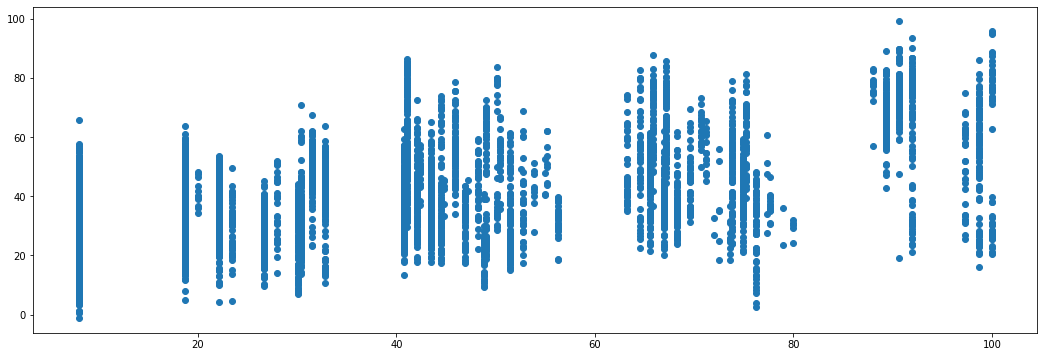

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)

# Full documents + Doc2VecDBOW + SVR

In [3]:
lang = "eng"
processed_full_doc_paths = get_doc_paths("../data/processed_doc2vec_full/", lang)
d2vv = Doc2VecVectorizer(dm=0, dm_mean=0)
d2vv.fit(processed_full_doc_paths)
df = d2vv.get_doc_vectors()
labels = read_labels("eng")
df['y'] = df["doc_path"].apply(lambda x: labels[x.split("/")[-1][:-4]])
df = df.drop(columns=['doc_path'])

INFO:root:Fitting Doc2VecVectorizer...
DEBUG:gensim.utils:starting a new internal lifecycle event log for Doc2Vec
INFO:gensim.utils:Doc2Vec lifecycle event {'params': 'Doc2Vec(dbow,d100,n5,mc2,s0.001,t4)', 'datetime': '2021-04-09T21:41:31.843950', 'gensim': '4.0.0', 'python': '3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:collected 176680 word types and 599 unique tags from a corpus of 599 examples and 60607461 words
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 103249 unique words (58.43841974190627%% of original 176680, drops 73431)', 'datetime': '2021-04-09T21:41:47.601120', 'gensim': '4.0.0', 'python': '3

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 144 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 148 jobs
INFO:gensim.models.word2vec:EPOCH - 1 : training on 60607461 raw words (5078904 effective words) took 7.0s, 728422 effective words/s
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 60607461 raw words (5078904 effective words) took 7.0s, 723360 effective words/s', 'datetime': '2021-04-09T21:42:10.779874', 'gensim': '4.0.0', 'python': '3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 10%|█         | 3/30 [00:21<03:10,  7.06s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 103249 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negativ

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 13.36% examples, 634714 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 26.71% examples, 660940 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 38.06% examples, 648549 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 51.25% examples, 644501 words/s, in_qsize 1, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 64.11% examples, 651165 words/s, in_qsize 0, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 79.47% examples, 672362 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 94.32% examples, 676994 words/s, in_qsize 0, out_qsize 0
DEBUG:gensim.models.word2vec:job loop exiting, total 582 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 144 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 139 jobs
INFO:gensim.models.word2vec:worker thread finished; aw

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 152 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 60607461 raw words (5079082 effective words) took 7.8s, 647308 effective words/s
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 60607461 raw words (5079082 effective words) took 7.9s, 646932 effective words/s', 'datetime': '2021-04-09T21:43:02.896186', 'gensim': '4.0.0', 'python': '3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 33%|███▎      | 10/30 [01:13<02:30,  7.51s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 103249 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-09T21:43:02.897859', 'gensi

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 26.71% examples, 674532 words/s, in_qsize 1, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 41.07% examples, 694548 words/s, in_qsize 1, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 55.59% examples, 706679 words/s, in_qsize 1, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 73.79% examples, 742806 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 85.31% examples, 716685 words/s, in_qsize 0, out_qsize 0
DEBUG:gensim.models.word2vec:job loop exiting, total 584 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 146 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 144 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 146 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 148 jobs
INFO:gensim.models.word2vec:worker thread finished; awai

INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 60607461 raw words (5079219 effective words) took 7.1s, 715655 effective words/s', 'datetime': '2021-04-09T21:43:53.593610', 'gensim': '4.0.0', 'python': '3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 57%|█████▋    | 17/30 [02:03<01:33,  7.23s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 103249 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-09T21:43:53.601480', 'gensim': '4.0.0', 'python': '3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 11.85% examples, 622361 words/s, in_qsize 1, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 26.38% examples, 668980 words/s, in_qsi

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 71.45% examples, 712169 words/s, in_qsize 0, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 84.97% examples, 702746 words/s, in_qsize 1, out_qsize 1
DEBUG:gensim.models.word2vec:job loop exiting, total 581 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 142 jobs
DEBUG:gensim.models.word2vec:worker exiting, processed 146 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 149 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 144 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 60607461 raw words (5078752 effective words) took 7.1s, 717314 effecti

 80%|████████  | 24/30 [02:54<00:43,  7.26s/it]INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 103249 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-04-09T21:44:44.594955', 'gensim': '4.0.0', 'python': '3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 13.19% examples, 675303 words/s, in_qsize 0, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 28.55% examples, 723126 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 43.07% examples, 737551 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 57.26% examples, 732541 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 74.12% examples, 753877 words/s, in_qsize 1, out_qsize 2
INFO:gensim.models.word

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
DEBUG:gensim.models.word2vec:worker exiting, processed 142 jobs
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 60607461 raw words (5078783 effective words) took 7.5s, 673653 effective words/s
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 60607461 raw words (5078783 effective words) took 7.5s, 673296 effective words/s', 'datetime': '2021-04-09T21:45:13.225582', 'gensim': '4.0.0', 'python': '3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.15.4-x86_64-i386-64bit', 'event': 'train'}
 93%|█████████▎| 28/30 [03:23<00:14,  7.29s/it]DEBUG:gensim.models.word2vec:worker exiting, pr

In [18]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df.drop(columns=['y']).values
y = df["y"].values.ravel()

all_predictions = []
all_labels = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for index, (train_indices, validation_indices) in enumerate(kf.split(X)):
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    validation_X = X[validation_indices, :]
    validation_y = y[validation_indices]
    
    model = MLPRegressor(hidden_layer_sizes=(80, 50, 30, 10), activation="relu", max_iter=50)
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 1, TrainMSE: 313.3580537577629, TrainMAE: 13.889223746221141, ValMSE: 798.2043880592305, ValMAE: 21.89570279992595


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 2, TrainMSE: 390.75117538613364, TrainMAE: 15.711998796499948, ValMSE: 526.1354345720483, ValMAE: 17.8090910628473


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 3, TrainMSE: 375.955217577623, TrainMAE: 15.322053107854899, ValMSE: 310.6160249243815, ValMAE: 14.59052984317925


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 4, TrainMSE: 362.16338457747077, TrainMAE: 15.026211117760374, ValMSE: 569.9851548841422, ValMAE: 20.076493152155987


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 5, TrainMSE: 442.00927607344823, TrainMAE: 16.717672853319762, ValMSE: 427.0220541216044, ValMAE: 17.378340755649415


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 6, TrainMSE: 374.5118145970833, TrainMAE: 15.378502720779077, ValMSE: 681.6376115284797, ValMAE: 20.9871627871961


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 7, TrainMSE: 385.1735827199042, TrainMAE: 15.445711488254227, ValMSE: 598.3124349373737, ValMAE: 19.893880240598968


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 8, TrainMSE: 412.27248102226457, TrainMAE: 16.137729803884113, ValMSE: 436.9282950201567, ValMAE: 16.603922993657655


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 9, TrainMSE: 387.5764150307395, TrainMAE: 15.699309737176268, ValMSE: 392.66812027177315, ValMAE: 15.723418098929335
Fold: 10, TrainMSE: 383.07681684583326, TrainMAE: 15.591048735356317, ValMSE: 346.0922483730858, ValMAE: 14.438886488170752


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


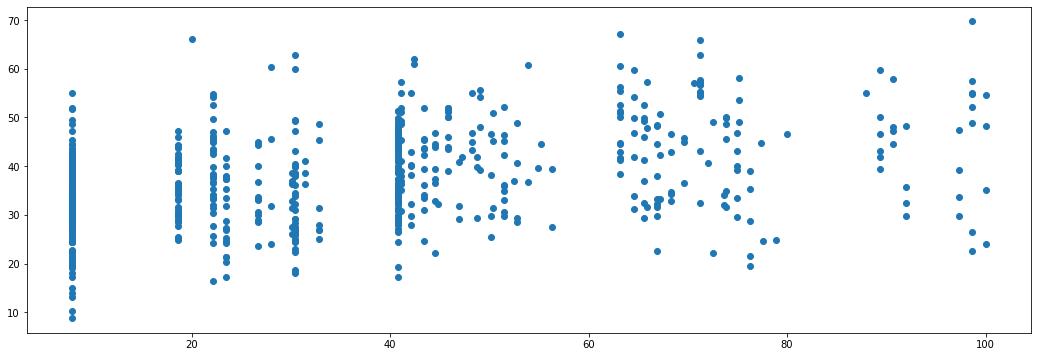

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.show();